In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import cov
import math
import pandas as pd
from pandas import Series
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')
dc = data[data['Status'] == 'Confirmed']['TT']
dc=list(dc)
t=data[data['Status']=='Confirmed']['Date']
t=list(t)
tt=[i for i in range(len(dc))]
f=dc

#Testing for stationarity
Here histogram is not gaussian so mean and variance of splitted dataset is not very meaningful so first we log transform.

**The line plot above clearly show an upward trend therefore the TS is not stationary**. ADF test is not needed.


Trying **log transform** to make the TS stationary

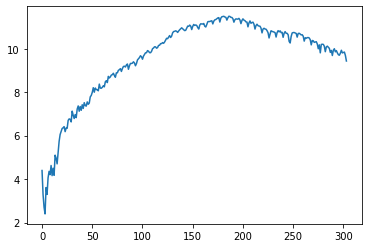

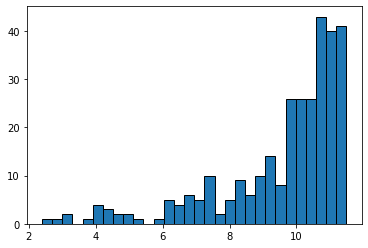

mean1=8.444434,mean2=10.757846
var1=4.303378,var2=0.275605


In [3]:
a=[i for i, e in enumerate(f) if e != 0]
f=np.array(f)
tt=np.array(tt)
f=f[a]
tt=tt[a]
flog=np.log(f)
plt.plot(tt,flog)
plt.show()
plt.hist(flog,bins=30,ec='black')
plt.show()
#a simple test for stationarity
split=int(len(flog)/2)
x1,x2=flog[0:split],flog[split:]
mean1,mean2=np.mean(x1),np.mean(x2)
var1,var2=np.var(x1,dtype=np.float64),np.var(x2,dtype=np.float64)
print('mean1=%f,mean2=%f'%(mean1,mean2))
print('var1=%f,var2=%f'%(var1,var2))

**Even after log trandsform TS is clearly not stationary.**

**Time series Decomposition**

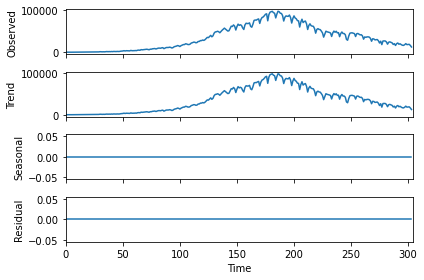

In [4]:
f=dc
tt=[i for i in range(len(dc))]
result=seasonal_decompose(f,model='additive',freq=1)
result.plot()
plt.show()

we can see from the graphs of the result that the time series contains trend and no seasonal component.Now this component can be removed 

**Detrending the TS by Differencing** \\
value(t) = observation(t)-observation(t-1)

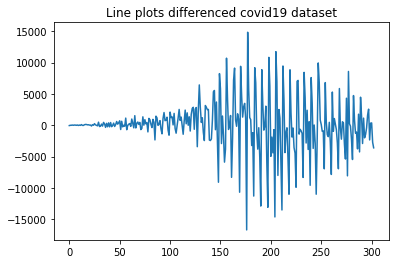

In [5]:
diff=list()
for i in range(1,len(f)):
    value=f[i]-f[i-1]
    diff.append(value)
plt.plot(diff)
plt.title('Line plots differenced covid19 dataset')
plt.show()

**ADF test to check for stationarity**

In [6]:
result=adfuller(diff)
print('ADF Statistic:%f'% result[0])
print('p-value:%f'% result[1])
print('critical Values:')
for key,value in result[4].items():
    print('\t%s: %.3f' %(key,value))

ADF Statistic:-2.173294
p-value:0.216081
critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


ADF test show p value is much greater than 0.05 that is: **Failed to reject the null hypothesis, the data has a unit root and is non-stationary.**Further comparing the test statistic to the critical value we can see it is larger that the critical values,so we would have to fail to reject the null hypothesis and so the time series is non-stationary and does have time-dependent structure.

**Differencing again and running ADF test again**

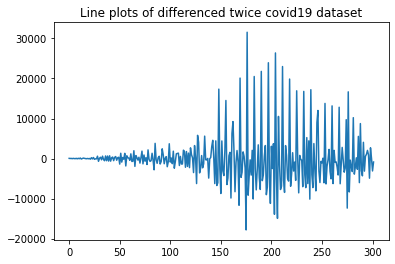

ADF Statistic:-6.416825
p-value:0.000000
critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
count      302.000000
mean       -11.758278
std       6222.568329
min     -17835.000000
25%      -2725.500000
50%       -156.000000
75%        963.750000
max      31550.000000
dtype: float64


In [7]:
f=diff
diff=list()
for i in range(1,len(f)):
    value=f[i]-f[i-1]
    diff.append(value)
plt.plot(diff)
plt.title('Line plots of differenced twice covid19 dataset')
plt.show()
result=adfuller(diff)
print('ADF Statistic:%f'% result[0])
print('p-value:%f'% result[1])
print('critical Values:')
for key,value in result[4].items():
    print('\t%s: %.3f' %(key,value))
series=Series(diff)
print(series.describe())

Doing the differencing again we see from test that **p value is less than 0.05 This suggests that we can reject the null hypothesis with a signicance level of less than 5% (i.e. a low probability that the result is a statistical fluke), or that we can reject the null hypothesis at 95% confidence means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.**

**Results clearly indicate the TS is now stationary**

#No erros in the TS so no noise is present.

#Computing ACF and PACF for the time series

**Autocorrelation Function (ACF).** The plot summarizes the correlation of an obser-
vation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.

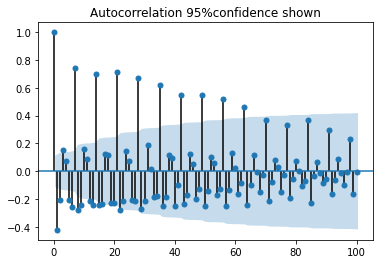

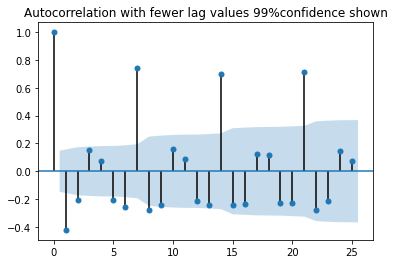

In [8]:
plot_acf(series,lags=100,title='Autocorrelation 95%confidence shown')
plt.show()
plot_acf(series,title='Autocorrelation with fewer lag values 99%confidence shown',alpha=0.01)
plt.show()

**Partial Autocorrelation Function (PACF)**. The plot summarizes the correlations for
an observation with lag values that is not accounted for by prior lagged observations.

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


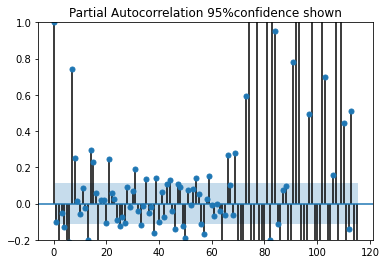

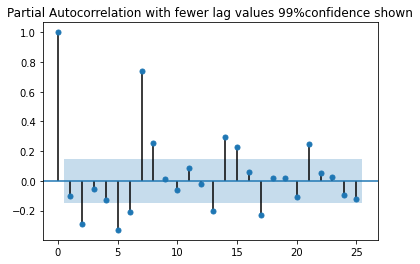

In [9]:
plot_pacf(f,lags=115,title='Partial Autocorrelation 95%confidence shown')
plt.ylim(-0.2,1)
plt.show()
plot_pacf(f,lags=25,alpha=0.01,title='Partial Autocorrelation with fewer lag values 99%confidence shown')
plt.show()

#Developing ARIMA model

Choosing the p,q and d parameters of the ARIMA \\
p: The number of lag observations included in the model, also called the lag order. \\
d: The number of times that the raw observations are differenced, also called the degreeof differencing. \\
q: The size of the moving average window, also called the order of moving average.

The model is AR if the ACF trails of after a lag and has a hard cut-off in the PACF after a lag. This lag is taken as the value for p. \\
The model is MA if the PACF trails of after a lag and has a hard cut-off in the ACF after the lag. This lag value is taken as the value for q.

**So looking at the respective plot we can take p around 6,q=0-3 since there is correlation in lag 1-3 and as
differencing is done twice to make the series stationary so d=2**

In [10]:
#fit model
series=Series(dc)
model=ARIMA(series,order=(6,2,0))
model_fit=model.fit(disp=0)
#summary of fit model
print(model_fit.summary())
residuals=DataFrame(model_fit.resid)

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  302
Model:                 ARIMA(6, 2, 0)   Log Likelihood               -2807.186
Method:                       css-mle   S.D. of innovations           2600.779
Date:                Tue, 12 Jan 2021   AIC                           5630.371
Time:                        10:25:03   BIC                           5660.055
Sample:                             2   HQIC                          5642.248
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1115     22.749     -0.093      0.926     -46.699      42.476
ar.L1.D2.y    -1.0095      0.032    -31.409      0.000      -1.072      -0.946
ar.L2.D2.y    -1.0296      0.041    -25.420      0.0

**The P-Values in ‘P>|z|’ column of the AR1,AR2,AR3,AR4,AR5 and AR6 terms are highly significant (<< 0.05).**

**Plotting the residuals to ensure there are no patterns (that is, look for constant mean and variance)**

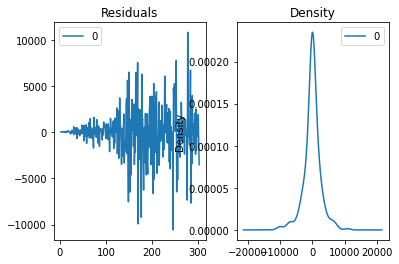

                  0
count    302.000000
mean       0.435879
std     2605.100470
min   -10575.238646
25%     -863.407334
50%       48.223279
75%      981.937975
max    10818.774101


In [11]:
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
print(residuals.describe())

**Forecasting with ARIMA**

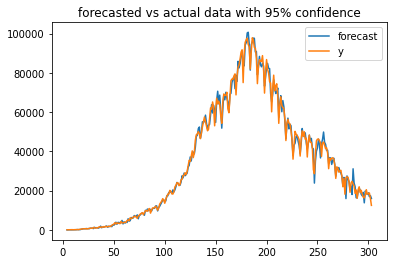

In [12]:
model_fit.plot_predict(dynamic=False) 
plt.title('forecasted vs actual data with 95% confidence')
plt.show()

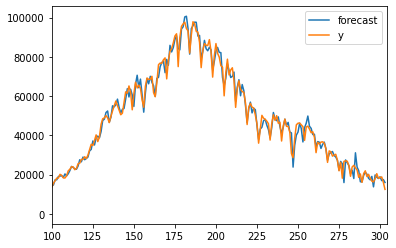

In [13]:
model_fit.plot_predict()
plt.xlim(100,len(tt))
plt.show()

**For Out-of-Time Cross validation we can now build the ARIMA model on training dataset, forecast and plot it to check how good our model is.**



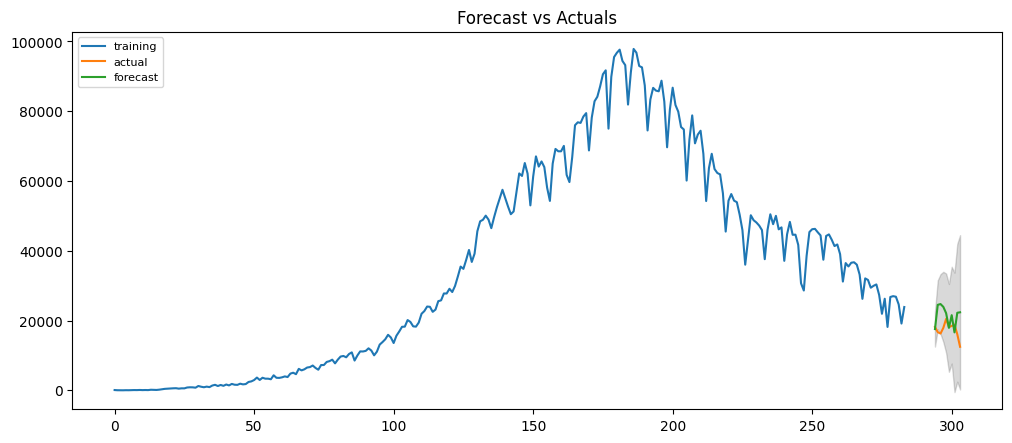

In [27]:
f=dc
train_value=len(f)-10
forecast_value=10

train = f[:train_value-forecast_value]

test = f[train_value:]

# Build Model
# model = ARIMA(train, order=(6,2,0))  
model = ARIMA(train, order=(6, 2, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(forecast_value, alpha=0.05)  # 95% conf
id=[i for i in range(train_value,len(f))]
# Make as pandas series
fc_series = Series(fc,index=id)
lower_series = Series(conf[:, 0],index=id)
upper_series = Series(conf[:, 1],index=id)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(id,test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
#plt.ylim(0,np.max(fc_series))
#plt.plot(tt[130:],f[130:])
plt.show()

**From the chart, the ARIMA(6,2,0) model seems to give a correct forecast. And the actual observed values lie within the 95% confidence band.**

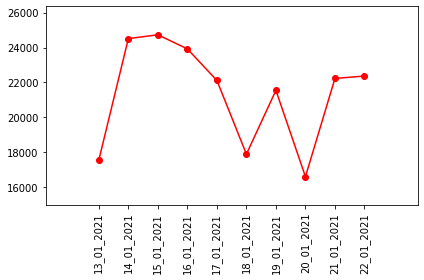

[17560.72590781 24508.6948226  24728.67952918 23922.25694977
 22115.58989625 17901.53397178 21548.53114594 16611.46026539
 22231.97529209 22367.25844276]


In [28]:

import datetime
import pylab
date=[]
for i in range(forecast_value):
    d=datetime.datetime.today() + datetime.timedelta(days=i+1)
    d=str(d.strftime ('%d_%m_%Y'))
    date.append(d)
date=[str(i) for i in date]
labels=date
fig=plt.figure()
plt.plot(id,fc,'ro-')
plt.xticks(id, labels, rotation='vertical')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
fig.savefig('forecast covid ')
plt.show()
f=open('forecasted_values.txt','a+')
for i in fc:
    i=str(i)
    f.write('%s\n'%(i))
f.close()

print(fc)